In [32]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import albumentations as A

In [33]:
# Custom wrapper for albumentations transforms
import numpy as np
from PIL import Image

class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        # Convert PIL Image to numpy array
        if isinstance(img, Image.Image):
            img = np.array(img)
        # Apply albumentations transform with named argument
        augmented = self.transform(image=img)
        return augmented['image']

In [34]:
data_dir = './datasets'
#Define the transformations
transforms = AlbumentationsTransform(A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
]))
#upload the dataset
full_dataset = ImageFolder(root=data_dir, transform=transforms)
 #For a third test set, you could adjust the calculation:
train_size = int(0.8 * len(full_dataset))
test_size = int(0.1 * len(full_dataset))
val_size = len(full_dataset) - train_size - test_size

In [35]:
#Get class names and number of classes
class_names = full_dataset.classes
num_classes = len(class_names)
print(f'Classes: {class_names}')
print(f'Number of classes: {num_classes}')

Classes: ['Lab', 'Tree', 'building', 'car', 'person']
Number of classes: 5


In [36]:
#spit the dataset into train, test, and validation sets
torch.manual_seed(42)
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, test_size, val_size])


In [37]:
#define data augmentations
train_transform = AlbumentationsTransform(A.Compose([
    A.RandomCrop(224,224),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.Blur(blur_limit=3, p=0.2),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
]))

val_transform = AlbumentationsTransform(A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2(),
]))
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform
train_dataset.dataset.transform = train_transform

/tmp/ipykernel_2987/95548952.py:8: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),


In [38]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [39]:
#import the model and modify the final layer
class CustomeResnet(nn.Module):
    def __init__(self, num_classes):
        super(CustomeResnet, self).__init__()
        self.model = torchvision.models.resnet34(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, in_features // 2),
            nn.BatchNorm1d(in_features // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features // 2, num_classes)
        )

    def forward(self, x):
        return self.model(x)
model = CustomeResnet(num_classes=num_classes)

In [40]:
# Calculate class weights to handle class imbalance
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Extract labels from the train dataset indices
train_labels = [full_dataset.targets[i] for i in train_dataset.indices]

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f'Class weights: {class_weights}')

Class weights: tensor([1.7302, 0.7294, 1.1022, 0.7750, 1.1717])


In [41]:
for param in model.model.parameters():
    param.requires_grad = False

for param in model.model.layer4.parameters():
    param.requires_grad = True
for param in model.model.layer3.parameters():
    param.requires_grad = True
for param in model.model.fc.parameters():
    param.requires_grad = True

In [43]:
#Define optimizer and loss function with learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [44]:
# change the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check GPU compatibility
if torch.cuda.is_available():
	print(f"GPU: {torch.cuda.get_device_name(0)}")
	print(f"CUDA Version: {torch.version.cuda}")
	print(f"PyTorch Version: {torch.__version__}")
	print(f"GPU Compute Capability: {torch.cuda.get_device_capability(0)}")

# Move model to device
model = model.to(device)
criterion = criterion.to(device)


Using device: cpu


In [45]:
# Check if CUDA is properly configured, otherwise use CPU
try:
    # Test CUDA with a simple operation
    test_tensor = torch.tensor([1.0]).to(device)
    test_result = test_tensor * 2
    print(f"CUDA test passed, using device: {device}")
except RuntimeError as e:
    print(f"CUDA error detected: {e}")
    print("Falling back to CPU")
    device = torch.device("cpu")
    model = model.to(device)
    criterion = criterion.to(device)

#Training loop with validation, learning rate scheduling, and model saving
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Step the scheduler based on validation loss
    scheduler.step(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'  Train Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print('  ✓ Best model saved!')
    print()

CUDA test passed, using device: cpu


/home/mohammad-boom/uniWork/Campus-Classificaton/.venv/lib/python3.13/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/50
  Train Loss: 1.3952, Train Acc: 39.99%
  Val Loss: 1.2904, Val Acc: 43.55%
  LR: 0.001000
  ✓ Best model saved!

Epoch 2/50
  Train Loss: 1.2557, Train Acc: 49.19%
  Val Loss: 1.5482, Val Acc: 39.25%
  LR: 0.001000

Epoch 3/50
  Train Loss: 1.2602, Train Acc: 47.98%
  Val Loss: 3.2299, Val Acc: 47.31%
  LR: 0.001000
  ✓ Best model saved!



KeyboardInterrupt: 

In [46]:
from sklearn.metrics import confusion_matrix, classification_report

# measure test accuracy
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 48.92%


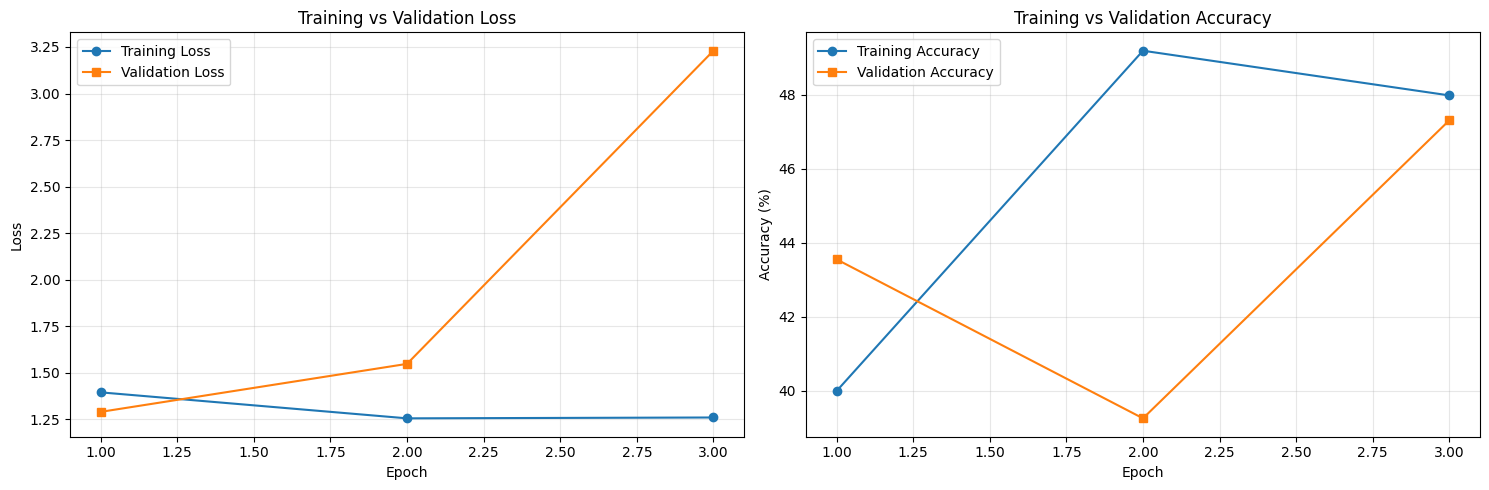

In [47]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(train_losses) + 1)

# Plot losses
ax1.plot(epochs, train_losses, label="Training Loss", marker='o')
ax1.plot(epochs, val_losses, label="Validation Loss", marker='s')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training vs Validation Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracies
ax2.plot(epochs, train_accuracies, label="Training Accuracy", marker='o')
ax2.plot(epochs, val_accuracies, label="Validation Accuracy", marker='s')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Training vs Validation Accuracy")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [48]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))

Confusion Matrix:
[[24  1  0  0  0]
 [ 3 39  6  0  1]
 [ 9  3 16  0  4]
 [14 18  2  8  6]
 [15  7  5  1  4]]
Classification Report:
              precision    recall  f1-score   support

         Lab       0.37      0.96      0.53        25
        Tree       0.57      0.80      0.67        49
    building       0.55      0.50      0.52        32
         car       0.89      0.17      0.28        48
      person       0.27      0.12      0.17        32

    accuracy                           0.49       186
   macro avg       0.53      0.51      0.44       186
weighted avg       0.57      0.49      0.44       186

